In [74]:
!nvidia-smi

Wed Jul  3 10:27:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.26                 Driver Version: 546.26       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti   WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   45C    P8               3W /  30W |    442MiB /  4096MiB |     22%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [76]:
import os

# Path to the directory you want to list
dataset_path = './srgan_dataset'

# List all files and folders in the directory
files = os.listdir(dataset_path)

# Print the list of files
for file in files:
    print(file)


change_names.ipynb
train_HR
train_LR
valid_HR
valid_LR


In [77]:
# Do set your runtime to GPU. You will need it
import torch
import math
from os import listdir
import numpy as np
from torch.autograd import Variable
from torchvision.io import read_image
from torchvision.transforms import Compose, RandomCrop, ToTensor, ToPILImage, CenterCrop, Resize,Normalize
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from os.path import join

import matplotlib
matplotlib.use('Qt5Agg')

import matplotlib.pyplot as plt

In [78]:
%matplotlib inline

In [79]:
torch.autograd.set_detect_anomaly(True)

In [80]:
UPSCALE_FACTOR = 1
CROP_SIZE = 160

In [81]:

#mean = np.array([0.485, 0.456, 0.406])
#std = np.array([0.229, 0.224, 0.225])
mean = np.array([0.5,0.5,0.5])
std = np.array([0.5,0.5,0.5])

In [82]:
# Now, I will load in some code for the dataset and dataloaders.
# Link to this notebook will be in the description, so you can get it from there
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG'])


def calculate_valid_crop_size(crop_size, upscale_factor):
    return crop_size - (crop_size % upscale_factor)


def train_hr_transform(crop_size):
    return Compose([
        RandomCrop(crop_size),
        ToTensor(),
    ])


def train_lr_transform(crop_size, upscale_factor):
    return Compose([
        RandomCrop(crop_size),
        ToTensor(),
    ])


def display_transform():
    return Compose([
        ToPILImage(),
        Resize(400),
        CenterCrop(400),
        ToTensor()
    ])


class TrainDatasetFromFolder(Dataset):
    def __init__(self, dataset_dir, crop_size, upscale_factor):
        super(TrainDatasetFromFolder, self).__init__()
        self.image_filenames = [join(dataset_dir, x) for x in listdir(dataset_dir) if is_image_file(x)]
        crop_size = calculate_valid_crop_size(crop_size, upscale_factor)
        self.hr_transform = train_hr_transform(crop_size)
        self.lr_transform = train_lr_transform(crop_size, upscale_factor)

    def __getitem__(self, index):
        hr_image = self.hr_transform(Image.open(self.image_filenames[index]))
        lr_image = self.lr_transform(hr_image)
        return lr_image, hr_image

    def __len__(self):
        return len(self.image_filenames)

In [83]:
class createDataset(Dataset):
    def __init__(self,dataset_path,data_type,crop_size=CROP_SIZE):
        super(Dataset, self).__init__()
        self.image_filenames = listdir(f"{dataset_path}/{data_type}_HR")
        self.path_HR = f"{dataset_path}/{data_type}_HR"
        self.path_LR = f"{dataset_path}/{data_type}_LR"
        self.crop_size = crop_size

    def __getitem__(self, index):
        image_filename = self.image_filenames[index]
        image_HR = read_image(join(self.path_HR,image_filename))
        image_HR = image_HR.type(torch.float)
        image_LR = read_image(join(self.path_LR,image_filename))
        image_LR = image_LR.type(torch.float)

        #TF.normalize(image_HR, mean=mean, std=std, inplace=True)
        #TF.normalize(image_LR, mean=mean, std=std, inplace=True)

        #image_HR = Normalize(mean=mean, std=std)(image_HR)
        #image_LR = Normalize(mean=mean, std=std)(image_LR)

        image_HR /= 255
        image_LR /= 255

        i, j, h, w = RandomCrop.get_params(image_HR, output_size=(self.crop_size, self.crop_size))
        image_HR = TF.crop(image_HR, i, j, h, w)
        image_LR = TF.crop(image_LR, i, j, h, w)

        return image_LR,image_HR

    def __len__(self):
        return len(self.image_filenames)

In [84]:
train_set = createDataset(dataset_path,"train")
trainloader = DataLoader(train_set,batch_size=16,shuffle=True)

torch.Size([16, 3, 160, 160]) torch.Size([16, 3, 160, 160])


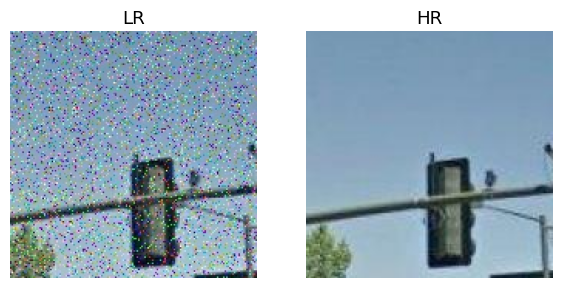

In [85]:
lrimages,hrimages = next(iter(trainloader))
print(lrimages.size(),hrimages.size())
n = np.random.randint(0,16)

fig,axes = plt.subplots(1,2,figsize=(7,14))
axes[0].imshow(lrimages[n].squeeze().permute(1,2,0))
axes[1].imshow(hrimages[n].squeeze().permute(1,2,0))
axes[0].axis("off")
axes[0].set_title("LR")
axes[1].axis("off")
axes[1].set_title("HR")
plt.show()

In [86]:
(lrimages).max(),(lrimages).min(),(lrimages).mean()

(tensor(1.), tensor(0.), tensor(0.39941))

In [87]:
from torch import nn, optim

In [14]:
# Now we will start implementing the model. We will start in this vid, and co,plee
# in the next video
class ResidualBlock(nn.Module):
  def __init__(self, channels):
    super(ResidualBlock, self).__init__()
    self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(channels)
    self.prelu = nn.PReLU()
    self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(channels)
  def forward(self, x):
    residual = self.conv1(x)
    residual = self.bn1(residual)
    residual = self.prelu(residual)
    residual = self.conv2(residual)
    residual = self.bn2(residual)
    return x + residual

# We just implemented a pretty standard residual block here

In [15]:
class UpsampleBlock(nn.Module):
  def __init__(self, in_channels, up_scale):
    super(UpsampleBlock, self).__init__()
    self.conv = nn.Conv2d(in_channels, in_channels * up_scale ** 2,
                          kernel_size=3, padding=1)
    self.pixel_shuffle = nn.PixelShuffle(up_scale)
    self.prelu = nn.PReLU()
  def forward(self, x):
    x = self.conv(x)
    x = self.pixel_shuffle(x)
    x = self.prelu(x)
    return x

In [16]:
class Generator(nn.Module):
  def __init__(self, scale_factor):
    super(Generator, self).__init__()
    upsample_block_num = int(math.log(scale_factor, 2))

    self.block1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=9, padding=4),
        nn.PReLU()
    )

    self.block2 = ResidualBlock(64)
    self.block3 = ResidualBlock(64)
    self.block4 = ResidualBlock(64)
    self.block5 = ResidualBlock(64)
    self.block6 = ResidualBlock(64)
    self.block7 = nn.Sequential(
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64)
    )
    block8 = [UpsampleBlock(64, 2) for _ in range(upsample_block_num)]
    block8.append(nn.Conv2d(64, 3, kernel_size=9, padding=4))
    self.block8 = nn.Sequential(*block8)
  def forward(self, x):
    block1 = self.block1(x)
    block2 = self.block2(block1)
    block3 = self.block3(block2)
    block4 = self.block4(block3)
    block5 = self.block5(block4)
    block6 = self.block6(block5)
    block7 = self.block7(block6)
    block8 = self.block8(block1 + block7)
    return (torch.tanh(block8) + 1) / 2

In [17]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.net = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, padding=1),
        nn.LeakyReLU(0.2),

        nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2),

        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2),

        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),

        nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),

        nn.Conv2d(256, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2),

        nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2),

        nn.AdaptiveAvgPool2d(1),
        nn.Conv2d(512, 1024, kernel_size=1),
        nn.LeakyReLU(0.2),
        nn.Conv2d(1024, 1, kernel_size=1)
    )
  def forward(self, x):
    batch_size=x.size()[0]
    return torch.sigmoid(self.net(x).view(batch_size))

In [18]:
# Path to the directory you want to list
models_path = './models'
CWNU_path = './'

In [19]:
import sys
#sys.path.append(models_path)
sys.path.append(CWNU_path)

from models.yolo import Model

In [20]:
custom_yolo_model = Model(cfg=models_path+"/custom_yolov5s.yaml")


                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Focus                     [3, 32, 3]                    
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     19904  models.common.BottleneckCSP             [64, 64, 1]                   
  3                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  4                -1  3    161152  models.common.BottleneckCSP             [128, 128, 3]                 
  5                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]              
  6                -1  3    641792  models.common.BottleneckCSP             [256, 256, 3]                 
  7                -1  1   1180672  models.common.Conv                      [256, 512, 3, 2]              
  8                -1  1    656896  

In [21]:
pre_trained_yolo_weights_path = './runs/train/yolov5s_results/weights'

# List all files and folders in the directory
files = os.listdir(pre_trained_yolo_weights_path)

if "best.pt" in files:
  print("Found")
else:
  print("Not Found")

Found


In [22]:
saved_dict = torch.load(pre_trained_yolo_weights_path+"/best.pt")
saved_dict

{'epoch': -1,
 'best_fitness': None,
 'model': Model(
   (model): Sequential(
     (0): Focus(
       (conv): Conv(
         (conv): Conv2d(12, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
         (act): SiLU(inplace=True)
       )
     )
     (1): Conv(
       (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
       (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
       (act): SiLU(inplace=True)
     )
     (2): BottleneckCSP(
       (cv1): Conv(
         (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
         (act): SiLU(inplace=True)
       )
       (cv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (cv3): Conv2d(32, 32, kernel_size=(1, 1), stride=(1,

In [23]:
# Now we got to make the Generator Loss
class TVLoss(nn.Module):
  def __init__(self, tv_loss_weight=1):
    super(TVLoss, self).__init__()
    self.tv_loss_weight=tv_loss_weight
  def forward(self, x):
    batch_size=x.size()[0]
    h_x = x.size()[2]
    w_x = x.size()[3]

    count_h = self.tensor_size(x[:, :, 1:, :])
    count_w = self.tensor_size(x[:, :, :, 1:])

    h_tv = torch.pow(x[:, :, 1:, :] - x[:, :, :h_x - 1, :], 2).sum()
    w_tv = torch.pow(x[:, :, :, 1:] - x[:, :, :, :w_x - 1], 2).sum()
    return self.tv_loss_weight * 2 * (h_tv / count_h + w_tv / count_w) / batch_size

  # Forgot to implement an important method
  @staticmethod # Must add this
  def tensor_size(t):
    return t.size()[1] * t.size()[2] * t.size()[3]

In [24]:
custom_yolo_model.load_state_dict(saved_dict["model"].state_dict())

<All keys matched successfully>

In [25]:
from models.yolo import Model

class YOLOv5FeatureExtractor(Model):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # self.load_state_dict()

    def load_another(self,inspo):
        self.model.load_state_dict(inspo)

    def forward(self, x):
        # Pass through layers upto the point you need (as an example, layer 3)
        x = self.model[0:9](x)
        return x

# Load your model
feature_extractor = YOLOv5FeatureExtractor(models_path+'/custom_yolov5s.yaml')
len(feature_extractor.model)

# img = torch.randn(5, 3, 640, 640)  # Example input
# features = feature_extractor(img)
# print(features.shape)


                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Focus                     [3, 32, 3]                    
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     19904  models.common.BottleneckCSP             [64, 64, 1]                   
  3                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  4                -1  3    161152  models.common.BottleneckCSP             [128, 128, 3]                 
  5                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]              
  6                -1  3    641792  models.common.BottleneckCSP             [256, 256, 3]                 
  7                -1  1   1180672  models.common.Conv                      [256, 512, 3, 2]              
  8                -1  1    656896  

25

In [26]:
custom_yolo_dict_keys = list(custom_yolo_model.state_dict().keys())
feature_extractor_dict_keys = list(feature_extractor.state_dict().keys())

for i in range(len(feature_extractor_dict_keys)):
  print(custom_yolo_dict_keys[i],"   -   ",feature_extractor_dict_keys[i])

model.0.conv.conv.weight    -    model.0.conv.conv.weight
model.0.conv.bn.weight    -    model.0.conv.bn.weight
model.0.conv.bn.bias    -    model.0.conv.bn.bias
model.0.conv.bn.running_mean    -    model.0.conv.bn.running_mean
model.0.conv.bn.running_var    -    model.0.conv.bn.running_var
model.0.conv.bn.num_batches_tracked    -    model.0.conv.bn.num_batches_tracked
model.1.conv.weight    -    model.1.conv.weight
model.1.bn.weight    -    model.1.bn.weight
model.1.bn.bias    -    model.1.bn.bias
model.1.bn.running_mean    -    model.1.bn.running_mean
model.1.bn.running_var    -    model.1.bn.running_var
model.1.bn.num_batches_tracked    -    model.1.bn.num_batches_tracked
model.2.cv1.conv.weight    -    model.2.cv1.conv.weight
model.2.cv1.bn.weight    -    model.2.cv1.bn.weight
model.2.cv1.bn.bias    -    model.2.cv1.bn.bias
model.2.cv1.bn.running_mean    -    model.2.cv1.bn.running_mean
model.2.cv1.bn.running_var    -    model.2.cv1.bn.running_var
model.2.cv1.bn.num_batches_tracked

In [27]:
ymd = custom_yolo_model.state_dict()
new_ymd = dict()

for k,v in ymd.items():
    new_ymd[k[6:]] = v

In [28]:
new_ymk = list(new_ymd.keys())
fek = list(feature_extractor.state_dict().keys())

counter=0

for i in range(len(new_ymk)):
    # print("model.",new_ymk[i]," - ",fek[i])
    if("model."+new_ymk[i]==fek[i]):
        counter+=1

counter

369

In [29]:
feature_extractor.load_another(new_ymd)

In [30]:
class GeneratorLoss(nn.Module):
  def __init__(self):
    super(GeneratorLoss, self).__init__()
    # vgg = vgg16(pretrained=True)
    # loss_network = nn.Sequential(*list(vgg.features)[:31]).eval()
    loss_network = feature_extractor
    for param in loss_network.parameters():
      param.requires_grad = False
    self.loss_network = loss_network
    self.mse_loss = nn.MSELoss()
    self.tv_loss = TVLoss()
  def forward(self, out_labels, out_images, target_images):
    adversial_loss = torch.mean(1 - out_labels)
    perception_loss = self.mse_loss(out_images, target_images)
    image_loss = self.mse_loss(out_images, target_images)
    tv_loss = self.tv_loss(out_images)
    return image_loss + 0.001 * adversial_loss + 0.006 * perception_loss + 2e-8 * tv_loss


In [41]:
device  = torch.device("cpu")
#device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Standard device selectoin
device

device(type='cpu')

In [42]:
netG = Generator(UPSCALE_FACTOR)
netD = Discriminator()

In [43]:
generator_criterion = GeneratorLoss()

In [44]:
generator_criterion = generator_criterion.to(device)
netG = netG.to(device)
netD = netD.to(device)

In [45]:
optimizerG = optim.Adam(netG.parameters(), lr=0.0002)
optimizerD = optim.Adam(netD.parameters(), lr=0.0002)

In [46]:
results = {
    "d_loss":[],
    "g_loss":[],
    "d_score": [],
    "g_score": []
}

In [47]:
## Now for training code
from tqdm import tqdm
import os

In [48]:
N_EPOCHS = 50 # 150 is good enough for our model. gives decent enough results

In [ ]:
for epoch in range(1, N_EPOCHS + 1):
  train_bar = tqdm(trainloader)
  running_results = {'batch_sizes':0, 'd_loss':0,
                     "g_loss":0, "d_score":0, "g_score":0}

  netG.train()
  netD.train()
  for data, target in train_bar:
    g_update_first = True
    batch_size = data.size(0)
    running_results['batch_sizes'] += batch_size

    real_img = Variable(target)
    real_img = real_img.to(device)
    z = Variable(data)
    z = z.to(device)

    ## Update Discriminator ##
    fake_img = netG(z)
    netD.zero_grad()
    real_out = netD(real_img).mean()
    fake_out = netD(fake_img).mean()
    d_loss = 1 - real_out + fake_out
    d_loss.backward(retain_graph = True)
    optimizerD.step()

    ## Now update Generator
    fake_img = netG(z)
    fake_out = netD(fake_img).mean()
    netG.zero_grad()
    g_loss = generator_criterion(fake_out, fake_img, real_img)
    g_loss.backward()

    fake_img = netG(z)
    fake_out = netD(fake_img).mean()

    optimizerG.step()

    running_results['g_loss'] += g_loss.item() * batch_size
    running_results['d_loss'] += d_loss.item() * batch_size
    running_results['d_score'] += real_out.item() * batch_size
    running_results['g_score'] += real_out.item() * batch_size

    ## Updating the progress bar
    train_bar.set_description(desc="[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f" % (
        epoch, N_EPOCHS, running_results['d_loss'] / running_results['batch_sizes'],
        running_results['g_loss'] / running_results['batch_sizes'],
        running_results['d_score'] / running_results['batch_sizes'],
        running_results['g_score'] / running_results['batch_sizes']
    ))
  netG.eval()

[1/50] Loss_D: 1.0042 Loss_G: 13485.3291 D(x): 0.4949 D(G(z)): 0.4949:   3%|▎         | 1/31 [01:34<47:27, 94.92s/it]

In [49]:
# Path to the directory you want to list
main_path = './srgan_results'

# List all files and folders in the directory
files = os.listdir(main_path)

# Print the list of files
for file in files:
    print(file)

discriminator_10epoch_crop160.pt
drive-download-20240702T140320Z-001.zip
generator_10epoch_crop160.pt


In [41]:
torch.save(netG.state_dict(),main_path+"/generator_50epoch_crop160.pt")
torch.save(netD.state_dict(),main_path+"/discriminator_50epoch_crop160.pt")

After training

In [50]:
srm = Generator(UPSCALE_FACTOR)
srm = srm
srm.load_state_dict(torch.load(main_path+"/generator_10epoch_crop160.pt",map_location=device))
srm.eval()

Generator(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): PReLU(num_parameters=1)
  )
  (block2): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=1)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block3): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=1)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block4): ResidualBlock(
    (conv1)

In [54]:
valid_set = createDataset(dataset_path,"valid")
validloader = DataLoader(valid_set,batch_size=16,shuffle=True)

In [55]:
!pip install PyQt6

  Using cached PyQt6-6.7.0-1-cp38-abi3-win_amd64.whl.metadata (2.1 kB)
  Using cached PyQt6_sip-13.6.0-cp310-cp310-win_amd64.whl.metadata (524 bytes)
  Using cached PyQt6_Qt6-6.7.2-py3-none-win_amd64.whl.metadata (551 bytes)
Using cached PyQt6-6.7.0-1-cp38-abi3-win_amd64.whl (6.6 MB)
   ---------------------------------------- 0.0/66.4 MB ? eta -:--:--
   ---------------------------------------- 0.4/66.4 MB 7.8 MB/s eta 0:00:09
    --------------------------------------- 1.3/66.4 MB 13.9 MB/s eta 0:00:05
    --------------------------------------- 1.4/66.4 MB 12.9 MB/s eta 0:00:06
   - -------------------------------------- 2.0/66.4 MB 10.7 MB/s eta 0:00:06
   - -------------------------------------- 2.2/66.4 MB 9.4 MB/s eta 0:00:07
   - -------------------------------------- 2.4/66.4 MB 8.6 MB/s eta 0:00:08
   - -------------------------------------- 2.5/66.4 MB 8.1 MB/s eta 0:00:08
   - -------------------------------------- 3.2/66.4 MB 8.5 MB/s eta 0:00:08
   -- --------------------

torch.Size([16, 3, 160, 160]) torch.Size([16, 3, 160, 160]) torch.Size([16, 3, 160, 160])


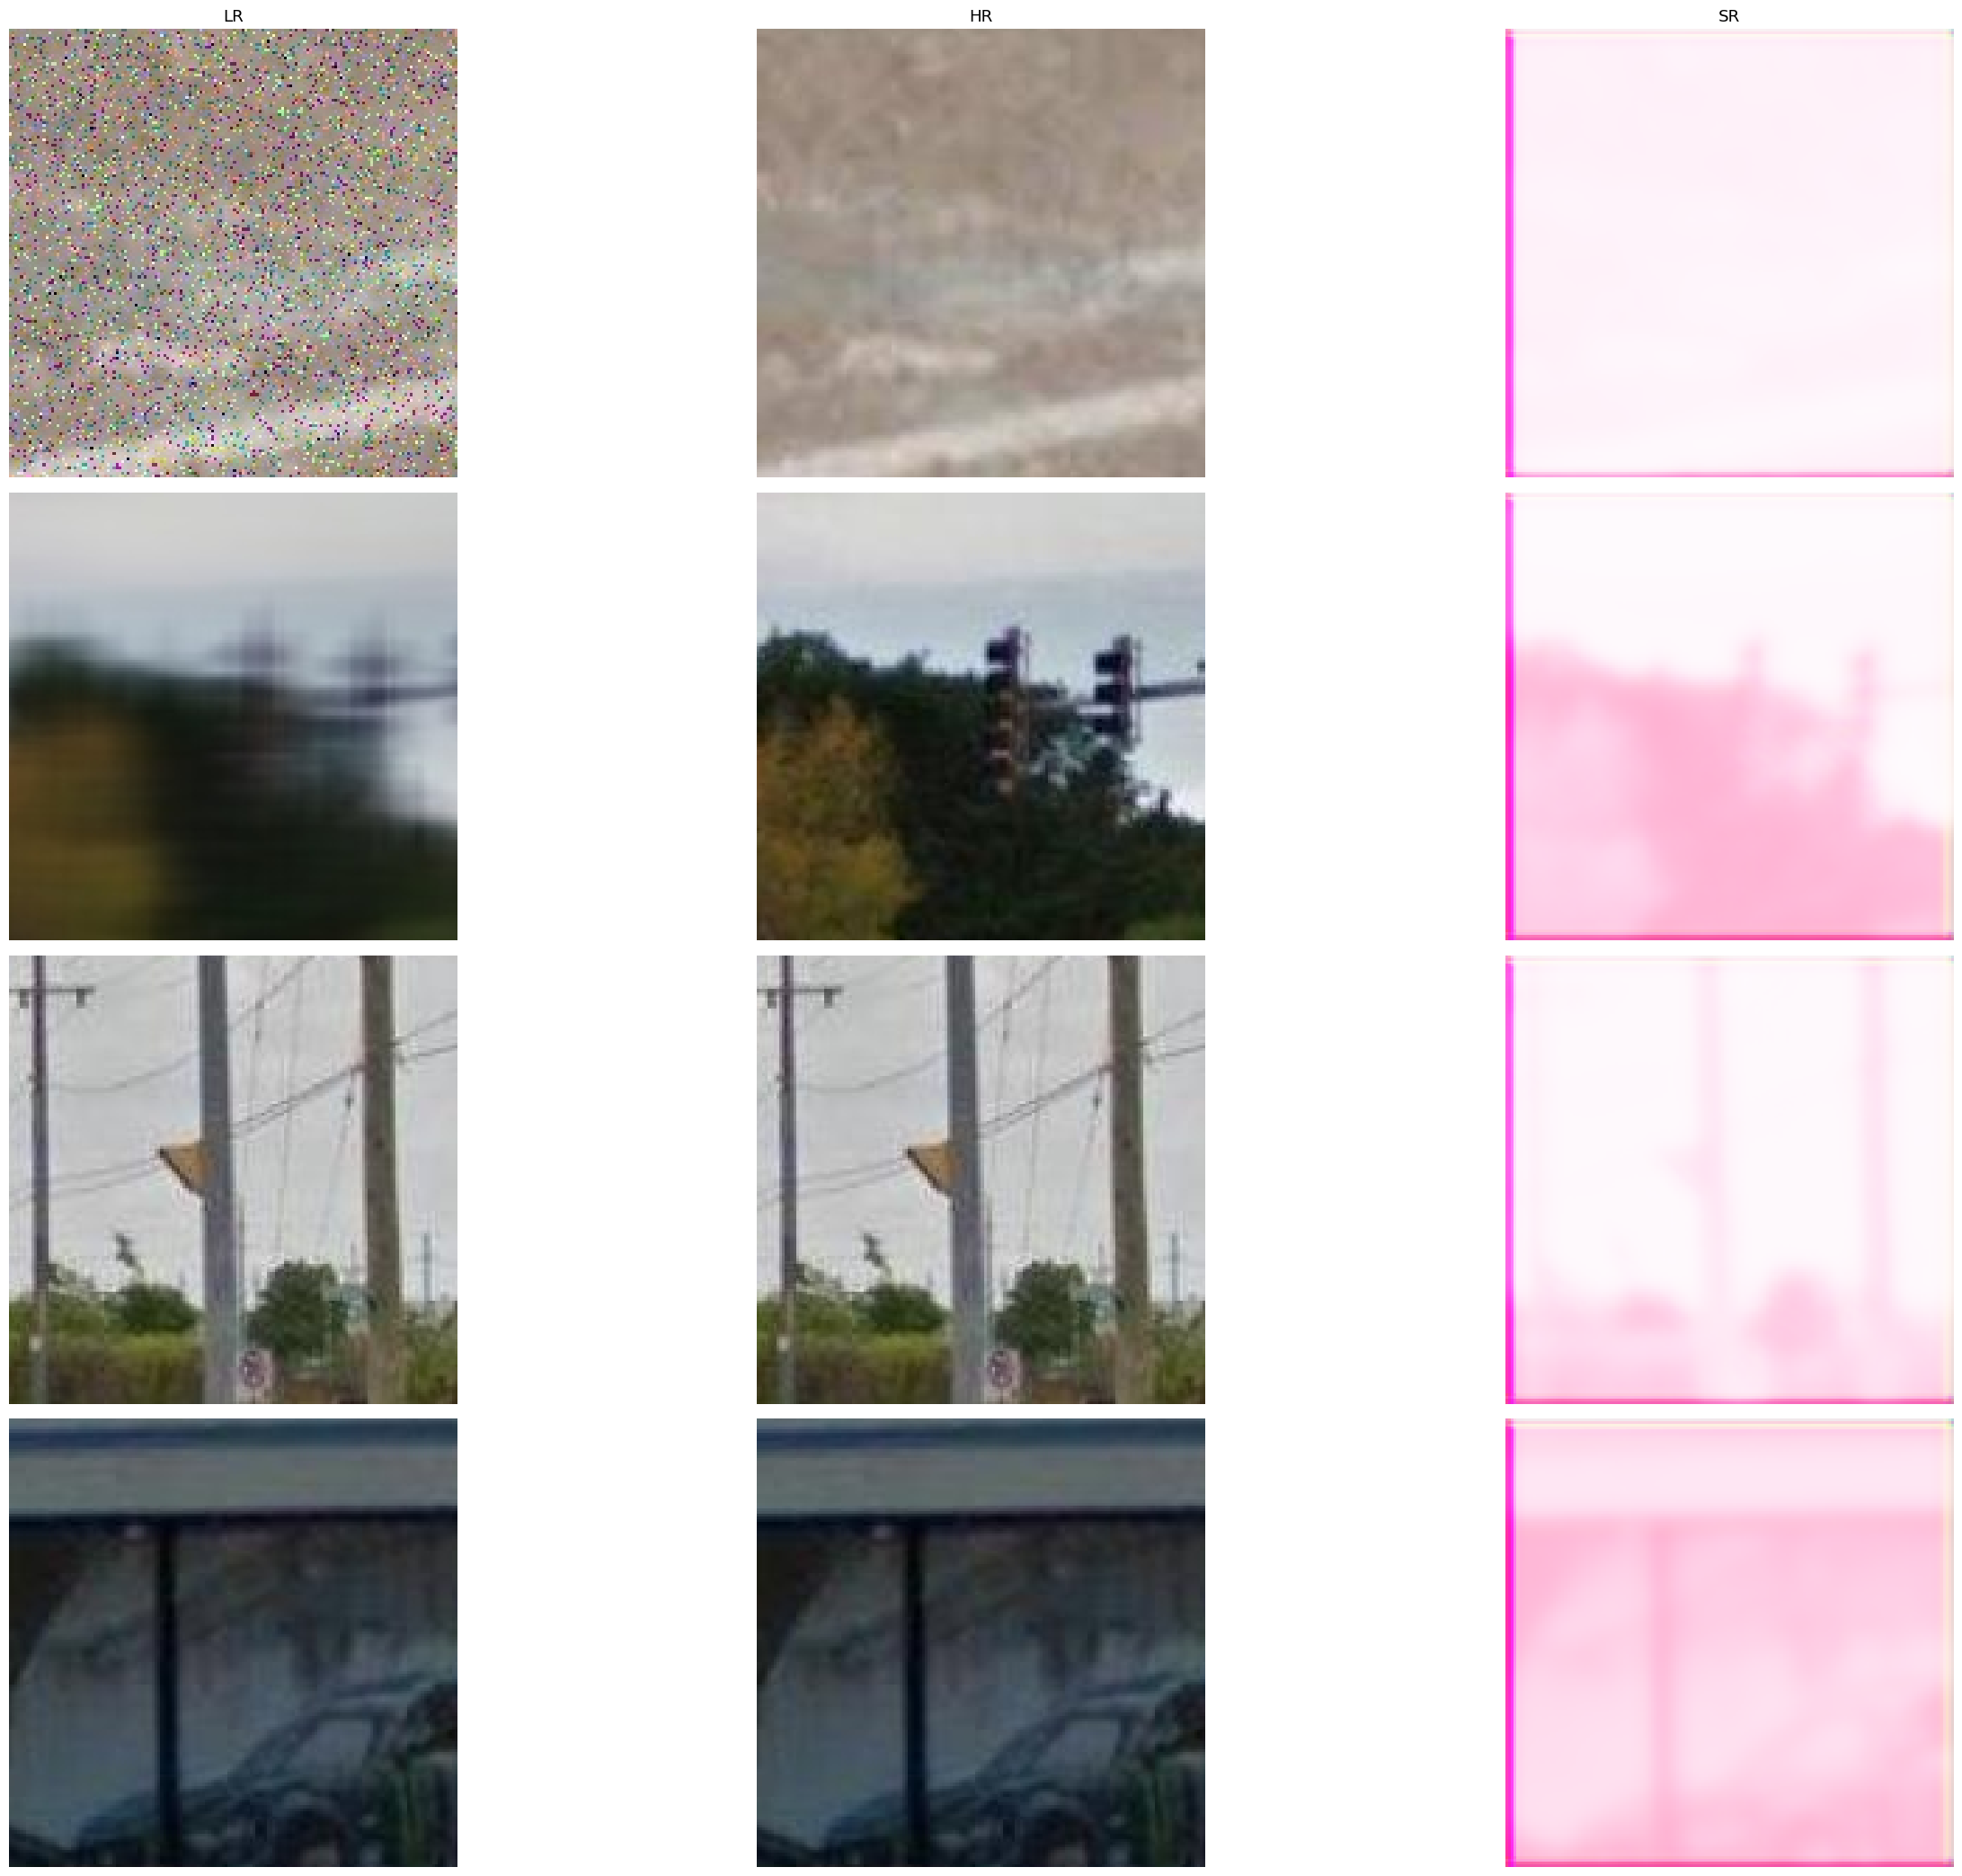

In [73]:
lrimages,hrimages = next(iter(validloader))
srimages = srm(hrimages).detach()
print(lrimages.size(),hrimages.size(),srimages.size())

fig,axes = plt.subplots(4,3,figsize=(28,21))

for i in range(4):  # Assuming we want to plot the first 4 images
    # Low-resolution image
    axes[i, 0].imshow(lrimages[i].squeeze().permute(1, 2, 0).numpy())
    axes[i, 0].axis("off")
    if i == 0:
        axes[i, 0].set_title("LR")

    # High-resolution image
    axes[i, 1].imshow(hrimages[i].squeeze().permute(1, 2, 0).numpy())
    axes[i, 1].axis("off")
    if i == 0:
        axes[i, 1].set_title("HR")

    # Model interpretation image
    axes[i, 2].imshow(srimages[i].permute(1, 2, 0).cpu().numpy())
    axes[i, 2].axis("off")
    if i == 0:
        axes[i, 2].set_title("SR")

plt.tight_layout()
plt.show()

In [70]:
(srimages).max(),(srimages).min(),(srimages).mean()

(tensor(0.99998, grad_fn=<MaxBackward1>),
 tensor(0.11685, grad_fn=<MinBackward1>),
 tensor(0.93776, grad_fn=<MeanBackward0>))

In [71]:
(hrimages).max(),(hrimages).min(),(hrimages).mean()

(tensor(1.), tensor(0.), tensor(0.41894))